**Table of contents**<a id='toc0_'></a>    
- [GAN (Sieci Generatywnych Przeciwników - Generative Adversarial Network)](#toc1_1_)    
    - [Przegląd procesu uczenia](#toc1_1_1_)    
  - [Zadania (4 punkty)](#toc1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

<table>
<tr>    
<td style="text-align: center">
<h1>Sieci Generatywnych Przeciwników - GAN</h1>
<h2><a href="http://home.agh.edu.pl/~horzyk/index.php">Adrian Horzyk</a></h2>
</td> 
<td>
<img src="http://home.agh.edu.pl/~horzyk/im/AdrianHorzyk49BT140h.png" alt="Adrian Horzyk, Professor" title="Adrian Horzyk, Professor" />        
</td> 
</tr>
</table>
<h3><i>Zapraszam do interaktywnego notebooka, w którym możesz dowiedzieć się, jak działają sieci neuronowe, doświadczysz i sprawdzisz ich działanie na wybranych zbiorach danych i przeprowadzisz własne eksperymenty!</i></h3>

## <a id='toc1_1_'></a>[GAN (Sieci Generatywnych Przeciwników - Generative Adversarial Network)](#toc0_)

Sieci GAN (Generative Adversarial Network) zostały wprowadzone w [2014 roku przez Iana Goodfellowa](https://arxiv.org/abs/1406.2661) i nazwane [„najciekawszym pomysłem ostatnich 10 lat w ML”](https:/ /www.kdnuggets.com/2016/08/yann-lecun-quora-session.html).
Celem podstawowej sieci GAN jest naśladowanie wejściowego zbioru danych poprzez generowanie nowych próbek danych o rozkładzie cech podobnym do podanego. Osiąga się to poprzez szkolenie dwóch podsieci, które konkurują ze sobą w grze o sumie zerowej:
  - dyskryminator - stara się odróżnić próbki prawdziwe od fałszywych. Jest to klasyfikacja w najbardziej podstawowym podejściu GAN;
  - generator - tworzy nowe próbki i próbuje oszukać dyskryminator, upodabniając wynik do wejściowego zbioru danych, jak to tylko możliwe.
 
Sieci GAN można wykorzystać do generowania obrazów, prozy, muzyki i mowy. Zastosowania możemy znaleźć w wielu dziedzinach artystycznych i kreatywnych. Z drugiej strony może też stać się podstawą do tworzenia deepfake’ów.

W tym notatniku postaramy się stworzyć rozwiązanie umożliwiające generowanie nowych obrazów ptaków. Zarówno w generatorze, jak i dyskryminatorze stosuje się warstwy splotu i transponowane warstwy splotu, aby efektywnie przetwarzać obrazy. Ta wersja sieci GAN jest czasami nazywana DCGAN (GAN o głębokim splocie).

Zbiór danych używany w tym notatniku można pobrać z [https://data.caltech.edu/records/20098](https://data.caltech.edu/records/20098).

In [1]:
!nvidia-smi

Tue May 17 14:20:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P5    20W /  N/A |    402MiB /  5934MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# For linux users:
# !wget -O birds.tgz https://data.caltech.edu/tindfiles/serve/1239ea37-e132-42ee-8c09-c383bb54e7ff/
# !tar zxvf birds.tgz

In [1]:
import tensorflow as tf
from tensorflow import keras, data
from tensorflow.keras import layers, models, utils

import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import pandas as pd
from tqdm import tqdm

Ponieważ szkolenie nawet podstawowej sieci GAN wymaga dużej mocy obliczeniowej, wszystkie obrazy zostały przeskalowane do rozmiaru 64x64.
W tym zbiorze danych autorzy podają informacje o obwiedniach ptaków na obrazach, więc ich przycięcie pozwoli nam uchwycić tylko najważniejsze cechy obrazów.
Zmienna **LATENT_DIM** odnosi się do rozmiaru wektora szumu, który będzie przekazywany jako sygnał wejściowy do sieci generatora (bez losowego wejścia generator generowałby za każdym razem ten sam sygnał wyjściowy). Zwykle będzie to realizowane w formie partii o kształcie [BATCH_SIZE, LATENT_DIM].

In [147]:
IMG_SIZE=64
BATCH_SIZE=64
LATENT_DIM=100

In [3]:
dataset_path = 'CUB_200_2011/'

# Read txt files containing info about the bounding boxes and the file paths
bboxes = pd.read_csv(dataset_path+'bounding_boxes.txt', sep = " ",names=["id","x","y","width","height"]).astype(int)
annotations = pd.read_csv(dataset_path+'images.txt', sep = " ",names=["id","path"])

processed = []

# Iterate through images, crop, scale and store them in 'processed' array
for index, row in tqdm(annotations.iterrows()):
    image_id = row.id                   #get image id
    image_path = row.path               #get image path
    bbox  = bboxes[bboxes.id == image_id].iloc[0]  #get bounding box values
    
    img = cv2.imread(dataset_path+"images/"+image_path) #read image
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)           #convert to RGB
    img = img[bbox.y:bbox.y+bbox.height,bbox.x:bbox.x+bbox.width,:] #crop image
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))           #resize
    img = tf.cast(img,'float32')/127.5 - 1              #normalize image to [-1,1]
    processed.append(img)                               #store in array

11788it [00:52, 223.83it/s]


In [148]:
# Create a tensorflow dataset from given data, shuffle images and group them into batches
limit_training = 10000
test = 300

processed = np.array(processed)
np.random.shuffle(processed)

train_dataset = data.Dataset.from_tensor_slices(processed[:limit_training]) \
                .shuffle(1024, reshuffle_each_iteration=True) \
                .batch(BATCH_SIZE)

test_dataset = data.Dataset.from_tensor_slices(processed[limit_training:limit_training + test]).batch(BATCH_SIZE)
print(train_dataset,test_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)> <BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


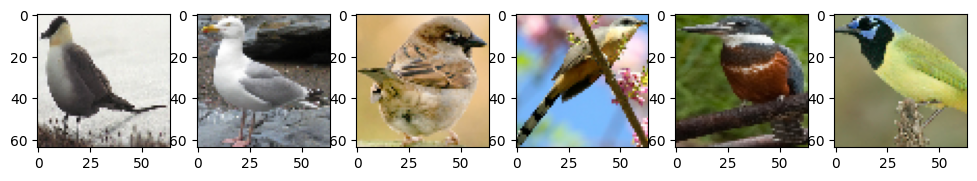

In [149]:
# Take a look at the dataset
imgs = next(iter(test_dataset))
fig = plt.figure(figsize=(12, 8))
rows = 6
for i in range(rows):
    fig.add_subplot(1,rows,i+1)
    plt.imshow((imgs[i]+1)*0.5) #scale images back to [0,1] in order to show them
plt.show()

Tworzenie generatora i dyskryminatora opartego na splocie wymaga użycia powtarzających się bloków niektórych warstw.
Aby zapewnić czystszy i prosty kod, warstwy te można pogrupować w bloki **Upsample** i **Downsample**.
Szkolenie sieci GAN może być zadaniem trudnym i nie ma optymalnego rozwiązania, dlatego przedstawiona architektura została wybrana arbitralnie. Istnieje jednak kilka ogólnych wskazówek, które mogą usprawnić trening, na przykład poprzez zastosowanie BatchNormalization, użycie LeakyReLU w dyskryminatorze i funkcji aktywacji ReLU w generatorze lub dodanie szumu do etykiet. Wpływ każdej zmiany wykracza poza zakres tego notatnika ze względu na długi czas uczenia pojedynczego eksperymentu.

In [150]:
class DownsampleBlock(layers.Layer):
    def __init__(self, filters, size, strides=2, padding='same',  use_bn=True):
        super().__init__()
        
        self.stack = keras.Sequential()
        self.stack.add(layers.Conv2D(filters, size, strides, padding))
            
        if use_bn:
            self.stack.add(layers.BatchNormalization(momentum=0.5))

        self.stack.add(layers.LeakyReLU(alpha=0.2))

    def call(self, inputs):
        return self.stack(inputs)

In [151]:
class UpsampleBlock(layers.Layer):
    def __init__(self, filters, size=4, strides=2, padding='same', use_bn=True):
        super().__init__()
        
        self.stack = keras.Sequential()
        self.stack.add(layers.Conv2DTranspose(filters, size, strides, padding))
        
        if use_bn:
            self.stack.add(layers.BatchNormalization(momentum=0.5))
            
        self.stack.add(layers.ReLU())

    def call(self, inputs):
        return self.stack(inputs)

Można dowolnie modyfikować przedstawioną architekturę, należy jednak pamiętać, że sieci GAN są bardzo wrażliwe i nawet niewielkie zmiany mogą czasami prowadzić do problemów i zepsucia szkolenia.
Jednym z najczęstszych problemów sieci GAN jest występowanie „załamania trybu” – co oznacza, że generator uczy się dostarczać tylko jeden rodzaj sygnału wyjściowego, pomimo szumu losowego na wejściu.
![Przykład zwijania trybu dla zbioru danych cyfr MNIST](https://api.wandb.ai/files/authors/images/projects/79890/a5fde269.png)
>Przykład zwijania trybu dla zbioru danych cyfr MNIST

Inny częsty problem może pojawić się podczas używania warstw Conv2DTranspose (odwrócony splot, który zasadniczo skaluje dane wyjściowe) w generatorze. Czasami na obrazie wyjściowym pojawia się wzór „szachownicy”.

In [159]:
def create_generator(input_size=LATENT_DIM):
    inp = layers.Input(shape=(input_size,))
    x = layers.Dense(4*4*256)(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Reshape((4,4,256))(x)
    x = UpsampleBlock(512,5)(x)
    x = UpsampleBlock(256,5)(x)
    x = UpsampleBlock(128,5)(x)
    x = layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="tanh")(x)
    return keras.models.Model(inp,x,name="generator")

generator = create_generator()

In [160]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_54 (Dense)            (None, 4096)              413696    
                                                                 
 batch_normalization_203 (Ba  (None, 4096)             16384     
 tchNormalization)                                               
                                                                 
 re_lu_108 (ReLU)            (None, 4096)              0         
                                                                 
 reshape_27 (Reshape)        (None, 4, 4, 256)         0         
                                                                 
 upsample_block_81 (Upsample  (None, 8, 8, 512)        3279360   
 Block)                                                  

In [182]:
def create_discriminator(input_size=(IMG_SIZE,IMG_SIZE,3)):
    inp = layers.Input(shape=input_size)
    x = DownsampleBlock(64, 5)(inp)
    x = DownsampleBlock(128, 5)(x)
    x = DownsampleBlock(256, 5)(x)
#     x = DownsampleBlock(512, 4)(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1,activation='sigmoid')(x)
    return keras.models.Model(inp,x,name="discriminator")


discriminator = create_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 downsample_block_115 (Downs  (None, 32, 32, 64)       5120      
 ampleBlock)                                                     
                                                                 
 downsample_block_116 (Downs  (None, 16, 16, 128)      205440    
 ampleBlock)                                                     
                                                                 
 downsample_block_117 (Downs  (None, 8, 8, 256)        820480    
 ampleBlock)                                                     
                                                                 
 flatten_32 (Flatten)        (None, 16384)             0         
                                                     

Wybór architektury ma ogromny wpływ na proces uczenia, ponieważ sieci GAN są szkolone w sposób min-max. Każda z dwóch podsieci może się doskonalić tylko kosztem drugiej, zatem dobre wyniki można osiągnąć jedynie w stanie równowagi.
Zbyt silny dyskryminator zdominuje generator i zbyt szybko nauczy się cech obrazu rzeczywistego, aby dać generatorowi szansę na znalezienie akceptowalnego i zróżnicowanego rozwiązania.
Zbyt słaby dyskryminator nigdy nie będzie w stanie uchwycić wystarczających cech, aby rozróżnić próbki prawdziwe od fałszywych wpływających na generator.

### <a id='toc1_1_1_'></a>[Przegląd procesu uczenia](#toc0_)
W procesie treningu GAN można wyróżnić dwa główne etapy:

1. Uczenie dyskryminatora – generator służy do generowania nowych próbek danych, następnie dyskryminator jest przekazywany zarówno rzeczywistym, jak i fałszywym partiom próbek oraz wynikami klasyfikacji wyników (w tym notatniku rzeczywiste obrazy są oznaczane „1” i generowane przez „0”). Celem dyskryminatora jest oszacowanie prawdopodobieństwa i rozróżnienie wyników prawdziwych od fałszywych. Na tym etapie aktualizowane są tylko wagi dyskryminatorów.

2. Uczenie generatora - generator jest zasilany jakimś losowym wektorem szumu i generuje nowe próbki, które są klasyfikowane przez dyskryminator (dyskryminator nie jest w tym kroku szkolony, jego wagi są zamrażane). Na tym etapie wygenerowane obrazy są oznaczane jako rzeczywiste (1), aby pobudzić generator do wygenerowania sygnału wyjściowego, który spowoduje awarię dyskryminatora. Aktualizacje wag dla generatora są obliczane poprzez propagację wsteczną błędu najpierw w sieci dyskryminatorów (chociaż warstwy dyskryminatorów pozostają zamrożone).
![proces szkolenia](https://developers.google.com/machine-learning/gan/images/gan_diagram.svg)


W celu wdrożenia tej procedury tworzony jest niestandardowy model GAN, który wymaga ręcznej aktualizacji wagi na etapie niestandardowego treningu.
Oprócz standardowych strat generatora i dyskryminatora śledzone są także dokładności dyskryminatora, aby zapewnić wgląd w równowagę treningową (aby sprawdzić, czy dyskryminator dobrze radzi sobie z obrazami rzeczywistymi i fałszywymi).

In [183]:
# Custom GAN model
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        '''Init model'''
        super().__init__()
        
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_optimizer, d_optimizer, g_loss_fn, d_loss_fn, latent_dim, **kwargs):
        '''Initialize metrics, optimizers and losses '''
        super().compile(**kwargs)
        
        self.g_loss_mean = keras.metrics.Mean(name="g_loss")
        self.d_loss_mean = keras.metrics.Mean(name="d_loss")
        
        self.real_acc = keras.metrics.BinaryAccuracy(name="real_acc")
        self.generated_acc = keras.metrics.BinaryAccuracy(name="gen_acc")
        
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        
        # In this example, the same loss function will be provided for both sub-networks (BinaryCrossentropy)
        # However; there are improved GAN variations that use different losses (like WGAN)
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.latent_dim = latent_dim
        
    @property
    def metrics(self):
        return [
            self.g_loss_mean,
            self.d_loss_mean,
            self.real_acc,
            self.generated_acc,
        ]
    
    
    def train_step(self,real_images):
        '''Perform one training step on a single batch of data.'''
        
        batch_size = tf.shape(real_images)[0]
        
        # 1. Train the discriminator
        
        # Generate some images
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim)) # Get noise for generator input
        generated_images = self.generator(random_noise) # Generate images for discriminator training step
        
        
        # Create labels for the discriminator
        # We assume 1 - real image, 0 - fake image + noise (important trick!)
        real_labels = tf.ones((batch_size, 1)) -  tf.random.uniform((batch_size,1)) * 0.15
        generated_labels = tf.random.uniform((batch_size,1)) * 0.15
        

        # Train the network, update weights manually
        # GradientTape is used to record all calculations inside the network and calculate gradient during backprop
        with tf.GradientTape() as tape:            
            # Divide into two steps because of BatchNormalization
            real_preds = self.discriminator(real_images)            # Predict classes for real images
            generated_preds = self.discriminator(generated_images)  # Predict classes for generated images

            # Labels and predictions of [real,fake] are merged for a discriminator loss function
            d_loss = self.d_loss_fn(tf.concat([real_labels,generated_labels],axis=0), # true labels
                                  tf.concat([real_preds,generated_preds],axis=0))     # predicted labels
          
        # Calculate discriminator gradients
        d_grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        # Apply weight changes
        self.d_optimizer.apply_gradients(zip(d_grads,self.discriminator.trainable_weights))


        #2. Train the generator
        #[2*] Because discriminator is trained on 2*batch_size number of samples (fake and real)
        random_noise = tf.random.normal(shape=(2*batch_size, self.latent_dim)) #get noise for generator input
        
        
        # During training, the generator tries to deceive the discriminator that it can generate realistic images
        # Therefore, we use "real (1)" labels for the generator
        misleading_labesl = tf.ones((2*batch_size,1))
        
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_noise) # Generate images
            fake_preds = self.discriminator(generated_images,training=False)
            g_loss = self.g_loss_fn(misleading_labesl, fake_preds)  
      
        # Calculate generator gradients
        g_grads = tape.gradient(g_loss, self.generator.trainable_weights)

        # Apply weight changes
        self.g_optimizer.apply_gradients(zip(g_grads,self.generator.trainable_weights))
        
        # Uupdate metrics
        self.g_loss_mean.update_state(g_loss)
        self.d_loss_mean.update_state(d_loss)
        self.real_acc.update_state(1.0, real_preds)
        self.generated_acc.update_state(0.0, generated_preds)
            
        return {'g_loss': g_loss, 'd_loss': d_loss, 
               'real_acc': self.real_acc.result(), 'gen_acc': self.generated_acc.result()}

Aby śledzić postęp szkolenia, zaimplementowano dwa niestandardowe wywołania zwrotne.
Pozwala nam zobaczyć, jak generator poprawia się na przestrzeni epok, poprzez wykreślenie obrazów tego samego losowego wektora.

In [184]:
class ImageProgress(keras.callbacks.Callback):
    def __init__(self,latent_dim,images=6,every_epoch=10):
        '''Provide latent_dim, number of images to plot and frequency.'''
        self.random_vectors = tf.random.normal((images,latent_dim))
        self.every_epoch = every_epoch
        images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch) % self.every_epoch == 0:
            generated_images = self.model.generator(self.random_vectors,training=False)
        
            fig = plt.figure(figsize=(12, 8))
            for i, image in enumerate(generated_images):
                fig.add_subplot(1,len(self.random_vectors),i+1)
                plt.imshow((image.numpy()+1)*0.5) # Scale output from [-1,1] to [0,1]
            plt.show()

In [185]:
discriminator = create_discriminator()
d_optimizer=keras.optimizers.Adam(0.0002, beta_1=0.5, beta_2=0.9)

generator = create_generator()
g_optimizer=keras.optimizers.Adam(0.00015, beta_1=0.5, beta_2=0.9)

In [186]:
gan = GAN(generator,discriminator)
gan.compile(g_optimizer,
            d_optimizer,
            keras.losses.BinaryCrossentropy(),
            keras.losses.BinaryCrossentropy(),
            LATENT_DIM)

Epoch 1/250
157/157 [==============================] - ETA: 0s - g_loss: 3.9980 - d_loss: 0.3846 - real_acc: 0.9439 - gen_acc: 0.9030

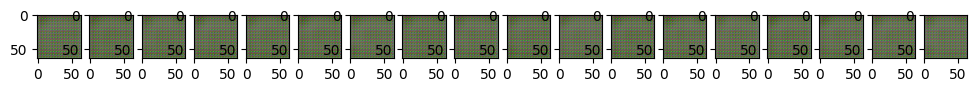

157/157 [==============================] - 36s 218ms/step - g_loss: 3.9980 - d_loss: 0.3846 - real_acc: 0.9439 - gen_acc: 0.9030
Epoch 2/250
157/157 [==============================] - 33s 210ms/step - g_loss: 4.6316 - d_loss: 0.3229 - real_acc: 0.9303 - gen_acc: 0.9628
Epoch 3/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.1349 - d_loss: 0.3750 - real_acc: 0.9298 - gen_acc: 0.9794
Epoch 4/250
157/157 [==============================] - 33s 210ms/step - g_loss: 3.2156 - d_loss: 0.3208 - real_acc: 0.9276 - gen_acc: 0.9885
Epoch 5/250
157/157 [==============================] - 33s 210ms/step - g_loss: 2.9991 - d_loss: 0.3207 - real_acc: 0.9181 - gen_acc: 0.9884
Epoch 6/250
157/157 [==============================] - 33s 210ms/step - g_loss: 3.1428 - d_loss: 0.3848 - real_acc: 0.9199 - gen_acc: 0.9954
Epoch 7/250
157/157 [==============================] - 33s 210ms/step - g_loss: 2.6408 - d_loss: 0.3528 - real_acc: 0.8535 - gen_acc: 0.9496
Epoch 8/250
157/157 [====

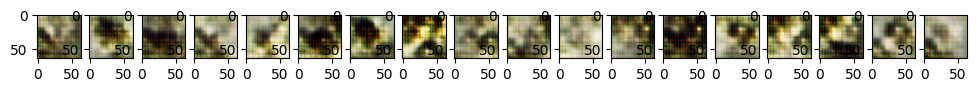

157/157 [==============================] - 34s 215ms/step - g_loss: 3.0859 - d_loss: 0.3739 - real_acc: 0.8162 - gen_acc: 0.9164
Epoch 12/250
157/157 [==============================] - 33s 210ms/step - g_loss: 2.0172 - d_loss: 0.6452 - real_acc: 0.8147 - gen_acc: 0.9136
Epoch 13/250
157/157 [==============================] - 33s 210ms/step - g_loss: 3.7126 - d_loss: 0.6437 - real_acc: 0.8295 - gen_acc: 0.9026
Epoch 14/250
157/157 [==============================] - 33s 210ms/step - g_loss: 4.1350 - d_loss: 0.3897 - real_acc: 0.8342 - gen_acc: 0.9061
Epoch 15/250
157/157 [==============================] - 33s 210ms/step - g_loss: 2.9104 - d_loss: 0.3867 - real_acc: 0.8763 - gen_acc: 0.9312
Epoch 16/250
157/157 [==============================] - 33s 210ms/step - g_loss: 2.8465 - d_loss: 0.4366 - real_acc: 0.8835 - gen_acc: 0.9268
Epoch 17/250
157/157 [==============================] - 33s 210ms/step - g_loss: 3.7070 - d_loss: 0.3733 - real_acc: 0.8772 - gen_acc: 0.9134
Epoch 18/250
157/15

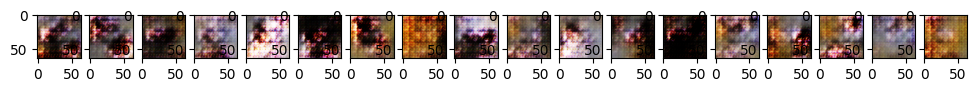

157/157 [==============================] - 34s 214ms/step - g_loss: 4.2197 - d_loss: 0.4056 - real_acc: 0.8842 - gen_acc: 0.9307
Epoch 22/250
157/157 [==============================] - 33s 210ms/step - g_loss: 3.3097 - d_loss: 0.3765 - real_acc: 0.8913 - gen_acc: 0.9372
Epoch 23/250
157/157 [==============================] - 33s 210ms/step - g_loss: 2.2070 - d_loss: 0.4835 - real_acc: 0.8917 - gen_acc: 0.9436
Epoch 24/250
157/157 [==============================] - 33s 210ms/step - g_loss: 4.4709 - d_loss: 0.6562 - real_acc: 0.8907 - gen_acc: 0.9377
Epoch 25/250
157/157 [==============================] - 33s 210ms/step - g_loss: 3.4019 - d_loss: 0.4276 - real_acc: 0.8804 - gen_acc: 0.9310
Epoch 26/250
157/157 [==============================] - 33s 210ms/step - g_loss: 2.8889 - d_loss: 0.3991 - real_acc: 0.8778 - gen_acc: 0.9263
Epoch 27/250
157/157 [==============================] - 33s 210ms/step - g_loss: 2.5934 - d_loss: 0.4672 - real_acc: 0.8656 - gen_acc: 0.9151
Epoch 28/250
157/15

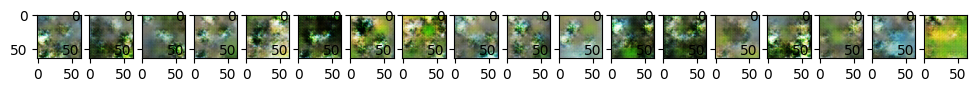

157/157 [==============================] - 34s 216ms/step - g_loss: 3.4772 - d_loss: 0.8155 - real_acc: 0.8597 - gen_acc: 0.9197
Epoch 32/250
157/157 [==============================] - 33s 209ms/step - g_loss: 3.7537 - d_loss: 0.4254 - real_acc: 0.8454 - gen_acc: 0.9126
Epoch 33/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.8834 - d_loss: 0.4313 - real_acc: 0.8545 - gen_acc: 0.9199
Epoch 34/250
157/157 [==============================] - 33s 210ms/step - g_loss: 2.1542 - d_loss: 0.5914 - real_acc: 0.8529 - gen_acc: 0.9138
Epoch 35/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.5583 - d_loss: 0.3758 - real_acc: 0.8587 - gen_acc: 0.9226
Epoch 36/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.8707 - d_loss: 0.5077 - real_acc: 0.8527 - gen_acc: 0.9204
Epoch 37/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.9615 - d_loss: 0.4317 - real_acc: 0.8609 - gen_acc: 0.9342
Epoch 38/250
157/15

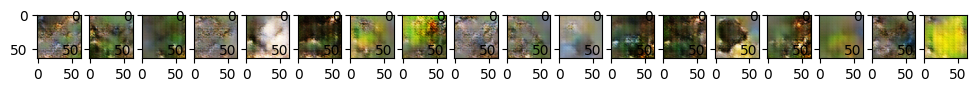

157/157 [==============================] - 34s 214ms/step - g_loss: 3.2403 - d_loss: 0.3590 - real_acc: 0.8805 - gen_acc: 0.9466
Epoch 42/250
157/157 [==============================] - 33s 209ms/step - g_loss: 3.4152 - d_loss: 0.4710 - real_acc: 0.8800 - gen_acc: 0.9464
Epoch 43/250
157/157 [==============================] - 33s 209ms/step - g_loss: 3.0314 - d_loss: 0.3062 - real_acc: 0.8700 - gen_acc: 0.9549
Epoch 44/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.7066 - d_loss: 0.5321 - real_acc: 0.8603 - gen_acc: 0.9465
Epoch 45/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.3478 - d_loss: 0.3485 - real_acc: 0.8618 - gen_acc: 0.9416
Epoch 46/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.3339 - d_loss: 0.3608 - real_acc: 0.8710 - gen_acc: 0.9466
Epoch 47/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.9834 - d_loss: 0.5034 - real_acc: 0.8712 - gen_acc: 0.9549
Epoch 48/250
157/15

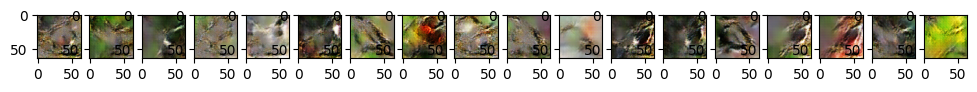

157/157 [==============================] - 37s 236ms/step - g_loss: 2.1696 - d_loss: 0.4068 - real_acc: 0.8501 - gen_acc: 0.9355
Epoch 52/250
157/157 [==============================] - 35s 224ms/step - g_loss: 2.3400 - d_loss: 0.4594 - real_acc: 0.8372 - gen_acc: 0.9218
Epoch 53/250
157/157 [==============================] - 36s 226ms/step - g_loss: 2.5001 - d_loss: 0.5152 - real_acc: 0.8200 - gen_acc: 0.9142
Epoch 54/250
157/157 [==============================] - 35s 222ms/step - g_loss: 1.8425 - d_loss: 0.4655 - real_acc: 0.8110 - gen_acc: 0.9064
Epoch 55/250
157/157 [==============================] - 36s 227ms/step - g_loss: 2.0333 - d_loss: 0.4722 - real_acc: 0.8152 - gen_acc: 0.9055
Epoch 56/250
157/157 [==============================] - 34s 213ms/step - g_loss: 2.0828 - d_loss: 0.3954 - real_acc: 0.8140 - gen_acc: 0.8990
Epoch 57/250
157/157 [==============================] - 34s 213ms/step - g_loss: 1.4078 - d_loss: 0.4984 - real_acc: 0.8107 - gen_acc: 0.9005
Epoch 58/250
157/15

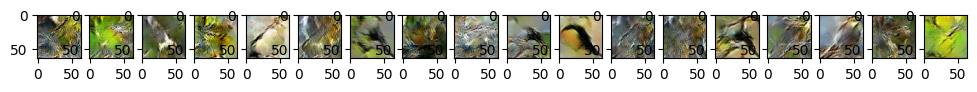

157/157 [==============================] - 35s 224ms/step - g_loss: 1.7929 - d_loss: 0.5660 - real_acc: 0.8100 - gen_acc: 0.9001
Epoch 62/250
157/157 [==============================] - 34s 214ms/step - g_loss: 1.5473 - d_loss: 0.5107 - real_acc: 0.7820 - gen_acc: 0.8813
Epoch 63/250
157/157 [==============================] - 33s 210ms/step - g_loss: 3.0046 - d_loss: 0.5367 - real_acc: 0.7905 - gen_acc: 0.8906
Epoch 64/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.2848 - d_loss: 0.4361 - real_acc: 0.7867 - gen_acc: 0.8812
Epoch 65/250
157/157 [==============================] - 33s 209ms/step - g_loss: 3.1483 - d_loss: 0.5036 - real_acc: 0.7781 - gen_acc: 0.8787
Epoch 66/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.3649 - d_loss: 0.5092 - real_acc: 0.7834 - gen_acc: 0.8779
Epoch 67/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.9619 - d_loss: 0.4258 - real_acc: 0.7692 - gen_acc: 0.8753
Epoch 68/250
157/15

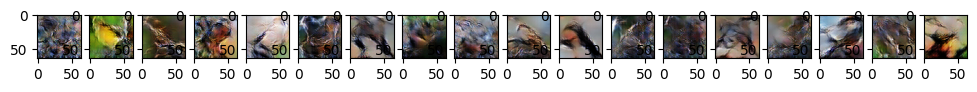

157/157 [==============================] - 34s 214ms/step - g_loss: 1.5939 - d_loss: 0.4949 - real_acc: 0.7732 - gen_acc: 0.8709
Epoch 72/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.9140 - d_loss: 0.5445 - real_acc: 0.7689 - gen_acc: 0.8686
Epoch 73/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.0403 - d_loss: 0.4802 - real_acc: 0.7687 - gen_acc: 0.8680
Epoch 74/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.9975 - d_loss: 0.5223 - real_acc: 0.7705 - gen_acc: 0.8641
Epoch 75/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.1137 - d_loss: 0.6212 - real_acc: 0.7667 - gen_acc: 0.8693
Epoch 76/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.6893 - d_loss: 0.4818 - real_acc: 0.7625 - gen_acc: 0.8660
Epoch 77/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.4698 - d_loss: 0.5707 - real_acc: 0.7717 - gen_acc: 0.8736
Epoch 78/250
157/15

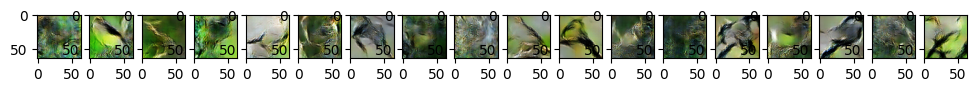

157/157 [==============================] - 34s 215ms/step - g_loss: 2.3292 - d_loss: 0.5967 - real_acc: 0.7644 - gen_acc: 0.8681
Epoch 82/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.2237 - d_loss: 0.5799 - real_acc: 0.7613 - gen_acc: 0.8785
Epoch 83/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.0010 - d_loss: 0.5607 - real_acc: 0.7725 - gen_acc: 0.8769
Epoch 84/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.3232 - d_loss: 0.5605 - real_acc: 0.7688 - gen_acc: 0.8767
Epoch 85/250
157/157 [==============================] - 33s 209ms/step - g_loss: 2.1638 - d_loss: 0.5545 - real_acc: 0.7669 - gen_acc: 0.8748
Epoch 86/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.2889 - d_loss: 0.6359 - real_acc: 0.7687 - gen_acc: 0.8733
Epoch 87/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.9697 - d_loss: 0.4909 - real_acc: 0.7634 - gen_acc: 0.8681
Epoch 88/250
157/15

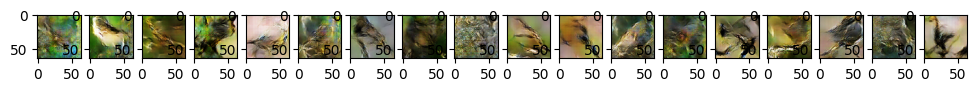

157/157 [==============================] - 33s 213ms/step - g_loss: 2.5807 - d_loss: 0.5161 - real_acc: 0.7644 - gen_acc: 0.8694
Epoch 92/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3665 - d_loss: 0.5098 - real_acc: 0.7550 - gen_acc: 0.8647
Epoch 93/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.2818 - d_loss: 0.5661 - real_acc: 0.7544 - gen_acc: 0.8643
Epoch 94/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6821 - d_loss: 0.4482 - real_acc: 0.7538 - gen_acc: 0.8633
Epoch 95/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.5374 - d_loss: 0.5830 - real_acc: 0.7671 - gen_acc: 0.8749
Epoch 96/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.1552 - d_loss: 0.5096 - real_acc: 0.7536 - gen_acc: 0.8587
Epoch 97/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.7457 - d_loss: 0.5595 - real_acc: 0.7542 - gen_acc: 0.8687
Epoch 98/250
157/15

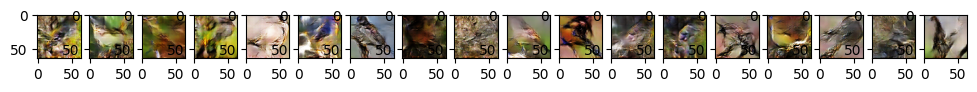

157/157 [==============================] - 33s 213ms/step - g_loss: 1.8962 - d_loss: 0.4370 - real_acc: 0.7502 - gen_acc: 0.8602
Epoch 102/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.7716 - d_loss: 0.5700 - real_acc: 0.7549 - gen_acc: 0.8603
Epoch 103/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.8209 - d_loss: 0.4629 - real_acc: 0.7502 - gen_acc: 0.8682
Epoch 104/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.1844 - d_loss: 0.4631 - real_acc: 0.7536 - gen_acc: 0.8620
Epoch 105/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.9619 - d_loss: 0.4426 - real_acc: 0.7545 - gen_acc: 0.8645
Epoch 106/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.8942 - d_loss: 0.5424 - real_acc: 0.7591 - gen_acc: 0.8689
Epoch 107/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.8484 - d_loss: 0.5081 - real_acc: 0.7622 - gen_acc: 0.8710
Epoch 108/250

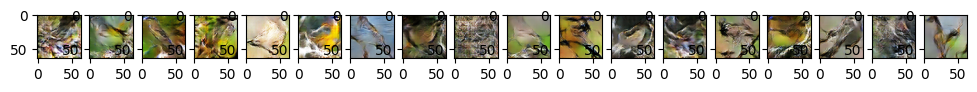

157/157 [==============================] - 33s 213ms/step - g_loss: 1.8084 - d_loss: 0.4790 - real_acc: 0.7583 - gen_acc: 0.8671
Epoch 112/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.7548 - d_loss: 0.5710 - real_acc: 0.7605 - gen_acc: 0.8724
Epoch 113/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.4601 - d_loss: 0.5112 - real_acc: 0.7567 - gen_acc: 0.8774
Epoch 114/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3226 - d_loss: 0.4547 - real_acc: 0.7618 - gen_acc: 0.8741
Epoch 115/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.9366 - d_loss: 0.4906 - real_acc: 0.7660 - gen_acc: 0.8710
Epoch 116/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6232 - d_loss: 0.4762 - real_acc: 0.7605 - gen_acc: 0.8703
Epoch 117/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.9654 - d_loss: 0.4167 - real_acc: 0.7695 - gen_acc: 0.8740
Epoch 118/250

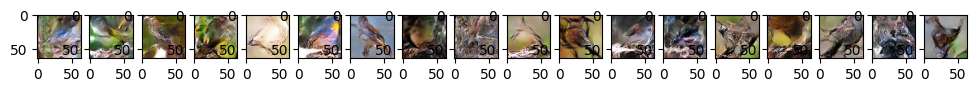

157/157 [==============================] - 34s 214ms/step - g_loss: 1.6529 - d_loss: 0.4499 - real_acc: 0.7737 - gen_acc: 0.8757
Epoch 122/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.5590 - d_loss: 0.5173 - real_acc: 0.7659 - gen_acc: 0.8699
Epoch 123/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.2694 - d_loss: 0.4475 - real_acc: 0.7743 - gen_acc: 0.8798
Epoch 124/250
157/157 [==============================] - 33s 209ms/step - g_loss: 1.8865 - d_loss: 0.5349 - real_acc: 0.7673 - gen_acc: 0.8672
Epoch 125/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.5888 - d_loss: 0.4983 - real_acc: 0.7664 - gen_acc: 0.8665
Epoch 126/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6962 - d_loss: 0.5124 - real_acc: 0.7705 - gen_acc: 0.8777
Epoch 127/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3844 - d_loss: 0.5224 - real_acc: 0.7799 - gen_acc: 0.8713
Epoch 128/250

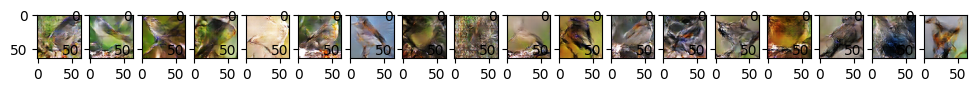

157/157 [==============================] - 33s 213ms/step - g_loss: 2.2015 - d_loss: 0.4333 - real_acc: 0.7775 - gen_acc: 0.8795
Epoch 132/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.2362 - d_loss: 0.4903 - real_acc: 0.7721 - gen_acc: 0.8711
Epoch 133/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.0706 - d_loss: 0.5350 - real_acc: 0.7735 - gen_acc: 0.8740
Epoch 134/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.1469 - d_loss: 0.4445 - real_acc: 0.7743 - gen_acc: 0.8729
Epoch 135/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.7142 - d_loss: 0.4735 - real_acc: 0.7755 - gen_acc: 0.8723
Epoch 136/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.4434 - d_loss: 0.4267 - real_acc: 0.7805 - gen_acc: 0.8751
Epoch 137/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.9655 - d_loss: 0.4325 - real_acc: 0.7761 - gen_acc: 0.8765
Epoch 138/250

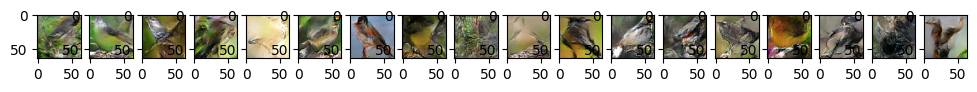

157/157 [==============================] - 33s 213ms/step - g_loss: 1.6293 - d_loss: 0.5036 - real_acc: 0.7867 - gen_acc: 0.8735
Epoch 142/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.9597 - d_loss: 0.5238 - real_acc: 0.7790 - gen_acc: 0.8670
Epoch 143/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.2373 - d_loss: 0.4526 - real_acc: 0.7847 - gen_acc: 0.8774
Epoch 144/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6915 - d_loss: 0.4303 - real_acc: 0.7857 - gen_acc: 0.8755
Epoch 145/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.7847 - d_loss: 0.4950 - real_acc: 0.7828 - gen_acc: 0.8690
Epoch 146/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.1686 - d_loss: 0.4768 - real_acc: 0.7805 - gen_acc: 0.8750
Epoch 147/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.4391 - d_loss: 0.5106 - real_acc: 0.7854 - gen_acc: 0.8751
Epoch 148/250

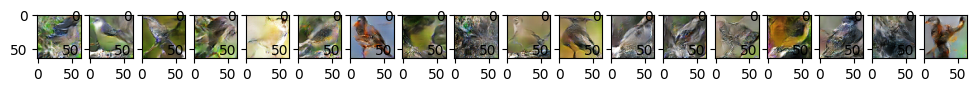

157/157 [==============================] - 33s 212ms/step - g_loss: 1.3107 - d_loss: 0.4712 - real_acc: 0.7870 - gen_acc: 0.8777
Epoch 152/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.8239 - d_loss: 0.4611 - real_acc: 0.7873 - gen_acc: 0.8741
Epoch 153/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6185 - d_loss: 0.4691 - real_acc: 0.7856 - gen_acc: 0.8746
Epoch 154/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.5378 - d_loss: 0.4861 - real_acc: 0.7900 - gen_acc: 0.8796
Epoch 155/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.9400 - d_loss: 0.5097 - real_acc: 0.7891 - gen_acc: 0.8771
Epoch 156/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3477 - d_loss: 0.5250 - real_acc: 0.7864 - gen_acc: 0.8665
Epoch 157/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.0083 - d_loss: 0.5448 - real_acc: 0.7941 - gen_acc: 0.8787
Epoch 158/250

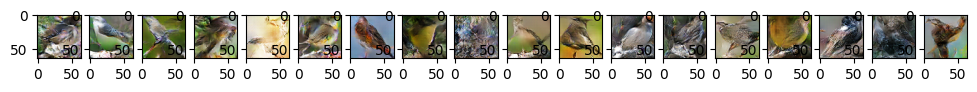

157/157 [==============================] - 33s 212ms/step - g_loss: 1.7123 - d_loss: 0.4006 - real_acc: 0.7932 - gen_acc: 0.8762
Epoch 162/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.8478 - d_loss: 0.5859 - real_acc: 0.7959 - gen_acc: 0.8738
Epoch 163/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6358 - d_loss: 0.5426 - real_acc: 0.7908 - gen_acc: 0.8722
Epoch 164/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3754 - d_loss: 0.5167 - real_acc: 0.7907 - gen_acc: 0.8746
Epoch 165/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.7335 - d_loss: 0.4410 - real_acc: 0.7943 - gen_acc: 0.8729
Epoch 166/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.0124 - d_loss: 0.5359 - real_acc: 0.7938 - gen_acc: 0.8750
Epoch 167/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6607 - d_loss: 0.4866 - real_acc: 0.7969 - gen_acc: 0.8763
Epoch 168/250

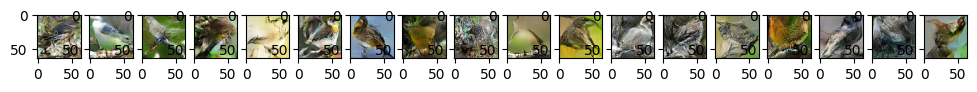

157/157 [==============================] - 34s 215ms/step - g_loss: 1.4366 - d_loss: 0.3830 - real_acc: 0.8010 - gen_acc: 0.8703
Epoch 172/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.8847 - d_loss: 0.4318 - real_acc: 0.7983 - gen_acc: 0.8763
Epoch 173/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.1166 - d_loss: 0.4973 - real_acc: 0.7954 - gen_acc: 0.8744
Epoch 174/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.4014 - d_loss: 0.5922 - real_acc: 0.7947 - gen_acc: 0.8670
Epoch 175/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.7065 - d_loss: 0.4710 - real_acc: 0.7923 - gen_acc: 0.8728
Epoch 176/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3446 - d_loss: 0.4755 - real_acc: 0.8005 - gen_acc: 0.8773
Epoch 177/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.7112 - d_loss: 0.4158 - real_acc: 0.7975 - gen_acc: 0.8679
Epoch 178/250

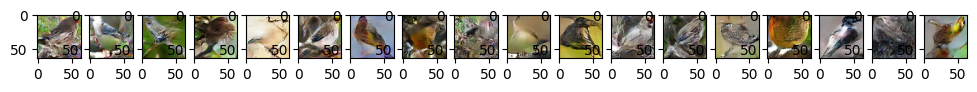

157/157 [==============================] - 33s 213ms/step - g_loss: 1.0536 - d_loss: 0.4562 - real_acc: 0.8036 - gen_acc: 0.8729
Epoch 182/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.4858 - d_loss: 0.4344 - real_acc: 0.8035 - gen_acc: 0.8739
Epoch 183/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.2640 - d_loss: 0.5203 - real_acc: 0.7971 - gen_acc: 0.8732
Epoch 184/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6923 - d_loss: 0.3968 - real_acc: 0.8078 - gen_acc: 0.8740
Epoch 185/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6523 - d_loss: 0.4952 - real_acc: 0.8092 - gen_acc: 0.8763
Epoch 186/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6913 - d_loss: 0.4434 - real_acc: 0.8068 - gen_acc: 0.8733
Epoch 187/250
157/157 [==============================] - 33s 208ms/step - g_loss: 0.7355 - d_loss: 0.4603 - real_acc: 0.8071 - gen_acc: 0.8769
Epoch 188/250

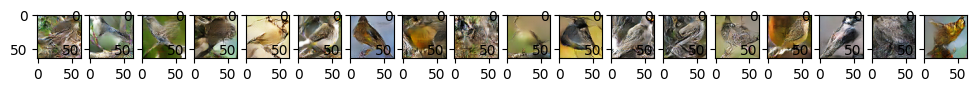

157/157 [==============================] - 33s 213ms/step - g_loss: 1.4330 - d_loss: 0.4803 - real_acc: 0.8033 - gen_acc: 0.8766
Epoch 192/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3194 - d_loss: 0.5438 - real_acc: 0.8130 - gen_acc: 0.8744
Epoch 193/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.5607 - d_loss: 0.4586 - real_acc: 0.8065 - gen_acc: 0.8711
Epoch 194/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.6298 - d_loss: 0.5954 - real_acc: 0.8103 - gen_acc: 0.8734
Epoch 195/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.4452 - d_loss: 0.4347 - real_acc: 0.8079 - gen_acc: 0.8708
Epoch 196/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.1038 - d_loss: 0.4635 - real_acc: 0.8144 - gen_acc: 0.8769
Epoch 197/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.4525 - d_loss: 0.4145 - real_acc: 0.8139 - gen_acc: 0.8770
Epoch 198/250

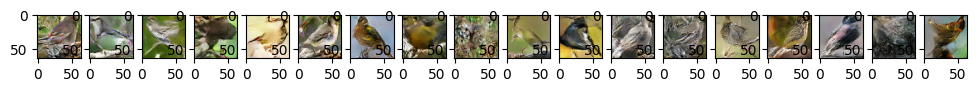

157/157 [==============================] - 33s 213ms/step - g_loss: 2.4276 - d_loss: 0.4545 - real_acc: 0.8129 - gen_acc: 0.8708
Epoch 202/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3491 - d_loss: 0.4400 - real_acc: 0.8145 - gen_acc: 0.8750
Epoch 203/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.7732 - d_loss: 0.4604 - real_acc: 0.8116 - gen_acc: 0.8731
Epoch 204/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.4132 - d_loss: 0.4458 - real_acc: 0.8154 - gen_acc: 0.8764
Epoch 205/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3748 - d_loss: 0.4645 - real_acc: 0.8193 - gen_acc: 0.8725
Epoch 206/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.5815 - d_loss: 0.4941 - real_acc: 0.8161 - gen_acc: 0.8740
Epoch 207/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3890 - d_loss: 0.6480 - real_acc: 0.8183 - gen_acc: 0.8764
Epoch 208/250

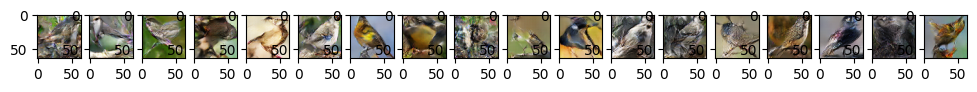

157/157 [==============================] - 33s 212ms/step - g_loss: 1.3900 - d_loss: 0.4605 - real_acc: 0.8142 - gen_acc: 0.8770
Epoch 212/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6839 - d_loss: 0.4763 - real_acc: 0.8161 - gen_acc: 0.8740
Epoch 213/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.4393 - d_loss: 0.4575 - real_acc: 0.8181 - gen_acc: 0.8732
Epoch 214/250
157/157 [==============================] - 33s 207ms/step - g_loss: 1.4932 - d_loss: 0.4120 - real_acc: 0.8220 - gen_acc: 0.8700
Epoch 215/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.1112 - d_loss: 0.3532 - real_acc: 0.8212 - gen_acc: 0.8766
Epoch 216/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.9511 - d_loss: 0.4555 - real_acc: 0.8277 - gen_acc: 0.8797
Epoch 217/250
157/157 [==============================] - 33s 207ms/step - g_loss: 1.5018 - d_loss: 0.4549 - real_acc: 0.8262 - gen_acc: 0.8776
Epoch 218/250

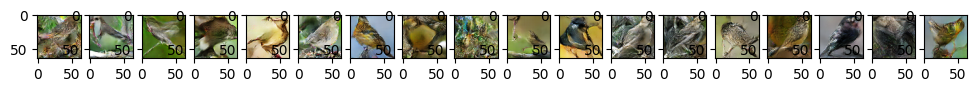

157/157 [==============================] - 34s 214ms/step - g_loss: 1.2143 - d_loss: 0.4471 - real_acc: 0.8253 - gen_acc: 0.8755
Epoch 222/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.6048 - d_loss: 0.3763 - real_acc: 0.8277 - gen_acc: 0.8783
Epoch 223/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.8453 - d_loss: 0.4134 - real_acc: 0.8257 - gen_acc: 0.8766
Epoch 224/250
157/157 [==============================] - 33s 207ms/step - g_loss: 1.3002 - d_loss: 0.4759 - real_acc: 0.8290 - gen_acc: 0.8768
Epoch 225/250
157/157 [==============================] - 33s 207ms/step - g_loss: 2.2773 - d_loss: 0.6284 - real_acc: 0.8307 - gen_acc: 0.8817
Epoch 226/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.8690 - d_loss: 0.3906 - real_acc: 0.8286 - gen_acc: 0.8745
Epoch 227/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.8782 - d_loss: 0.4515 - real_acc: 0.8372 - gen_acc: 0.8829
Epoch 228/250

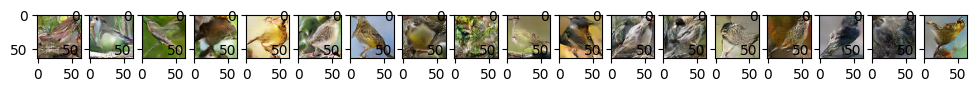

157/157 [==============================] - 33s 212ms/step - g_loss: 1.6708 - d_loss: 0.4001 - real_acc: 0.8351 - gen_acc: 0.8786
Epoch 232/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.9373 - d_loss: 0.3785 - real_acc: 0.8361 - gen_acc: 0.8830
Epoch 233/250
157/157 [==============================] - 33s 207ms/step - g_loss: 2.3652 - d_loss: 0.4973 - real_acc: 0.8392 - gen_acc: 0.8831
Epoch 234/250
157/157 [==============================] - 33s 207ms/step - g_loss: 1.9150 - d_loss: 0.4532 - real_acc: 0.8366 - gen_acc: 0.8760
Epoch 235/250
157/157 [==============================] - 33s 207ms/step - g_loss: 1.6584 - d_loss: 0.4133 - real_acc: 0.8368 - gen_acc: 0.8854
Epoch 236/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.3588 - d_loss: 0.3909 - real_acc: 0.8371 - gen_acc: 0.8867
Epoch 237/250
157/157 [==============================] - 33s 208ms/step - g_loss: 2.4348 - d_loss: 0.4769 - real_acc: 0.8397 - gen_acc: 0.8814
Epoch 238/250

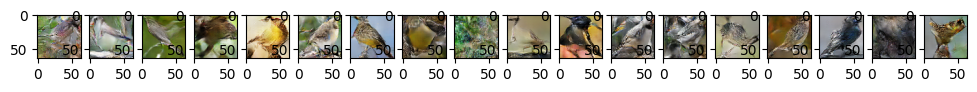

157/157 [==============================] - 33s 212ms/step - g_loss: 1.9622 - d_loss: 0.6019 - real_acc: 0.8439 - gen_acc: 0.8900
Epoch 242/250
157/157 [==============================] - 33s 207ms/step - g_loss: 1.1328 - d_loss: 0.4126 - real_acc: 0.8426 - gen_acc: 0.8778
Epoch 243/250
157/157 [==============================] - 33s 207ms/step - g_loss: 1.5602 - d_loss: 0.5745 - real_acc: 0.8400 - gen_acc: 0.8796
Epoch 244/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.2043 - d_loss: 0.4658 - real_acc: 0.8423 - gen_acc: 0.8833
Epoch 245/250
157/157 [==============================] - 33s 208ms/step - g_loss: 1.3352 - d_loss: 0.4351 - real_acc: 0.8448 - gen_acc: 0.8861
Epoch 246/250
157/157 [==============================] - 33s 207ms/step - g_loss: 2.6897 - d_loss: 0.3768 - real_acc: 0.8483 - gen_acc: 0.8854
Epoch 247/250
157/157 [==============================] - 33s 207ms/step - g_loss: 1.4965 - d_loss: 0.4380 - real_acc: 0.8421 - gen_acc: 0.8848
Epoch 248/250

In [187]:
history = gan.fit(train_dataset,
        epochs=250,
        callbacks=[ImageProgress(LATENT_DIM)]) 

In [188]:
g_loss, d_loss, real_acc, fake_acc = history.history.values()

In [189]:
generator.save_weights("generator.h5")
discriminator.save_weights("discriminator.h5")

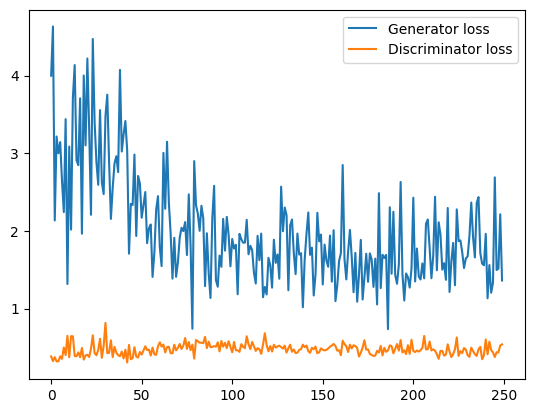

In [190]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

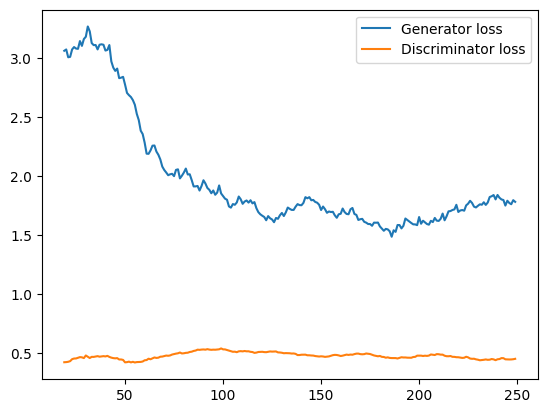

In [205]:
# Lets take a look at the smoothed plot (Simple Moving Average)

window_size = 20
# Convert array of integers to pandas series
d_sma_loss = pd.Series(d_loss)
g_sma_loss = pd.Series(g_loss)
  
# Get the window of series of observations of the specified window size
d_sma_loss = d_sma_loss.rolling(window_size).mean()
g_sma_loss = g_sma_loss.rolling(window_size).mean()

# Convert pandas series back to list
d_sma_loss = d_sma_loss.tolist()
g_sma_loss = g_sma_loss.tolist()

plt.plot(g_sma_loss)
plt.plot(d_sma_loss)
plt.legend(['Generator loss','Discriminator loss'])
plt.show()

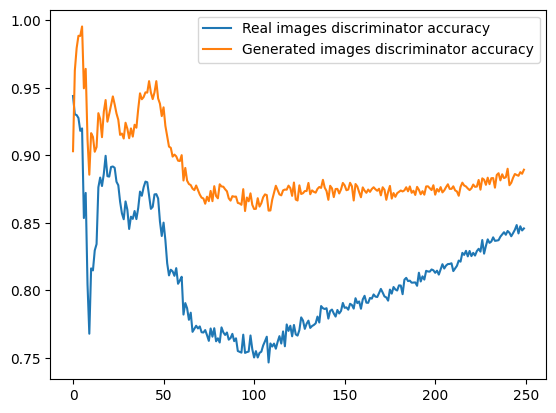

In [191]:
plt.plot(real_acc)
plt.plot(fake_acc)
plt.legend(['Real images discriminator accuracy','Generated images discriminator accuracy'])
plt.show()

Powyższy wykres strat i dokładności pokazuje, że proces uczenia sieci GAN jest wysoce niestabilny. Generator na początku osiągnął duży postęp, przyjmując podstawowe cechy obrazu, a następnie zwolnił. Wykres strat pokazuje, że sieć była dobrze zrównoważona, a obie sieci w pewnym momencie osiągnęły zbieżność. Być może szkolenie dałoby się przedłużyć na kolejne epoki; jednak wygładzony wykres pokazuje, że generator zaczął spadać po epoce ~180 pod względem strat.


Dokładności pokazują, że na początku dyskryminatorowi bardzo łatwo było rozróżnić dane rzeczywiste od wygenerowanych (w zasadzie na początku był to szum), ale później wynik spadł ze względu na szybkie początkowe udoskonalenie generatora. Wraz z postępem szkolenia na obrazach zaczęło pojawiać się więcej szczegółów i złożonych funkcji, które sieć dostosowywała.

Zwykle po procesie szkolenia nie ma już potrzeby zatrzymywania dyskryminatora; do wytworzenia nowych próbek danych można teraz używać wyłącznie przeszkolonego generatora.

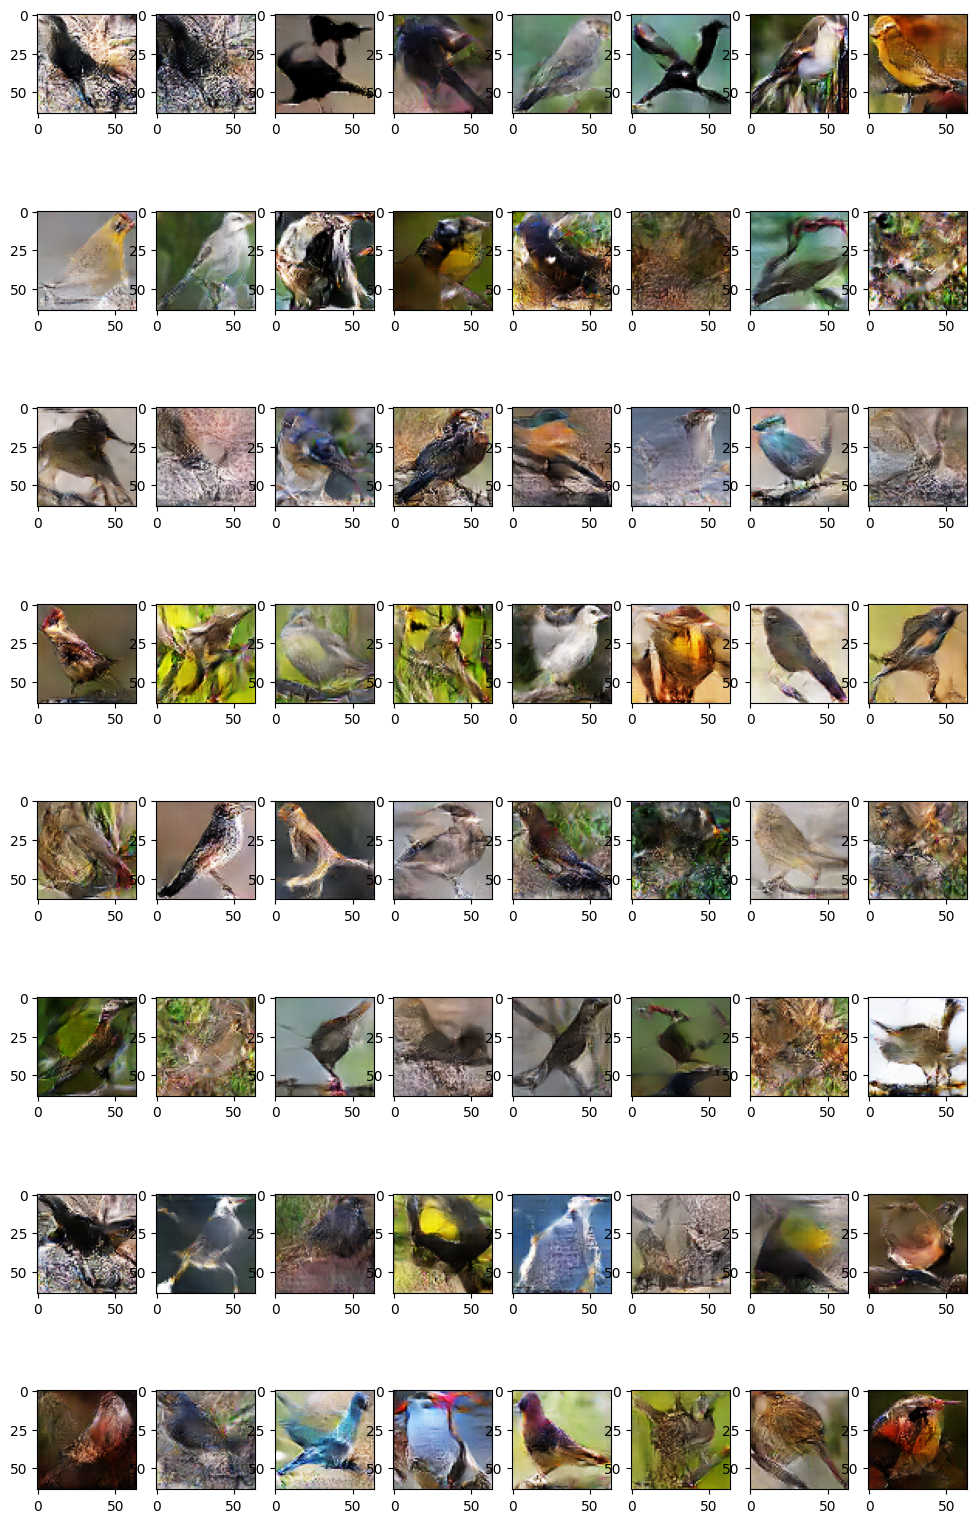

In [192]:
noise = tf.random.normal((64,LATENT_DIM))
generated = generator(noise,training=False)
fig = plt.figure(figsize=(12,20))
for i in range(8):
  for j in range(8):
    fig.add_subplot(8,8,i*8+j+1)
    plt.imshow((generated[i*8+j]+1)*0.5)
plt.show()

Przedstawione wyniki należy uznać za dobre, gdyż wykorzystano jedynie najbardziej podstawową architekturę GAN, bez jakiejkolwiek regularyzacji czy trenowania metod stabilizacji specyficznych dla GAN. Większość obrazów ma kształty przypominające ptaki, a niektórym brakuje szczegółów lub są pełne dziwnych artefaktów, ale problem ten wynika z dużej złożoności zbioru danych – 200 gatunków różnych ptaków w różnych pozach i niejednolitym tle . Podstawowe podejście splotowe nie jest również w stanie zachować relacji na duże odległości między pikselami/cechami na wygenerowanym obrazie.

Jeszcze jednym przykładem jest wpływ manipulacji ukrytym wektorem na obraz wyjściowy. Szum lub wektor utajony podany jako dane wejściowe podczas procesu uczenia może kodować określone cechy wyniku końcowego.

In [254]:
# 1. averaging two vectors
examples = 6
noise_1 = np.random.normal(size=(examples,LATENT_DIM))
noise_2 = np.random.normal(size=(examples,LATENT_DIM))
merged = (noise_1 + noise_2)/2 #mean

imgs_1 = generator(noise_1,training=False)
imgs_2 = generator(noise_2,training=False)
result = generator(merged,training=False)

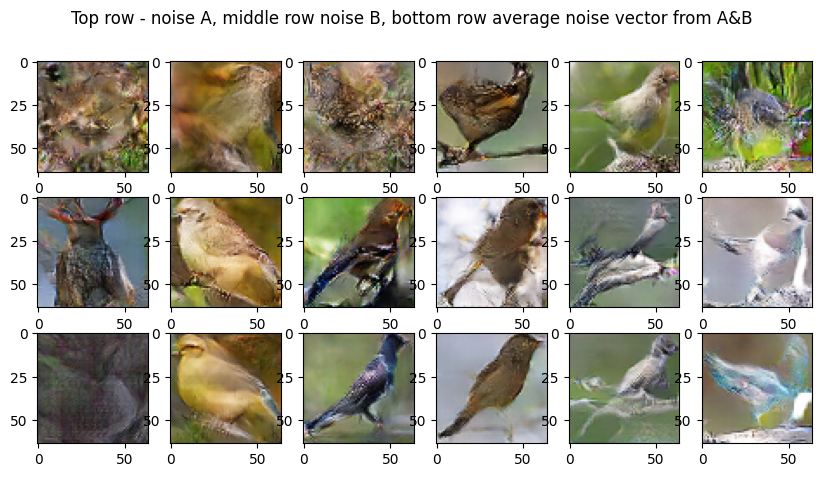

In [255]:
fig = plt.figure(figsize=(10,5))
for i, (a,b,c) in enumerate(zip(imgs_1,imgs_2,result)):
    fig.add_subplot(3,examples,1+i)
    plt.imshow((a+1)*0.5)
    fig.add_subplot(3,examples,examples+i+1)
    plt.imshow((b+1)*0.5)
    fig.add_subplot(3,examples,2*examples+i+1)
    plt.imshow((c+1)*0.5)

fig.suptitle("Top row - noise A, middle row noise B, bottom row average noise vector from A&B")
plt.show()

Manipulacje dokonane wektorem utajonym nie są już tak oczywiste. Uśrednianie czasami daje wiarygodne wyniki ze zrozumiałymi zmianami, takimi jak zmiany w teksturze lub wielkości ptaka.

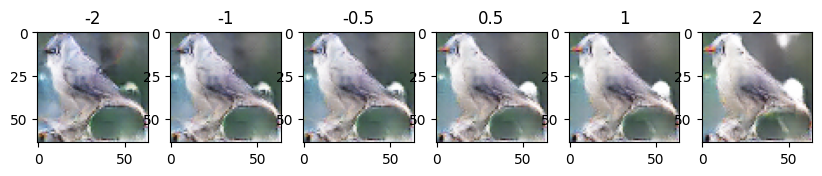

In [250]:
# Feature manipulation (changing single value in the original noise vector) 
noise = np.random.normal(size=(1,LATENT_DIM))
vals = [-2,-1,-0.5,0.5,1,2]                  # values to check
feature = 55                                 # from [0,LATENT_DIM-1]

def plot_feature_change(values,feature,noise):
    fig = plt.figure(figsize=(10,4))
    for index, shift in enumerate(values):
        noise_changed = np.copy(noise)
        noise_changed[0,feature] += shift
        image = generator(noise_changed)
        fig.add_subplot(1,len(vals),1+index)
        plt.imshow((image[0]+1)/2)
        plt.title(shift)
    plt.show()

plot_feature_change(vals,feature,noise)

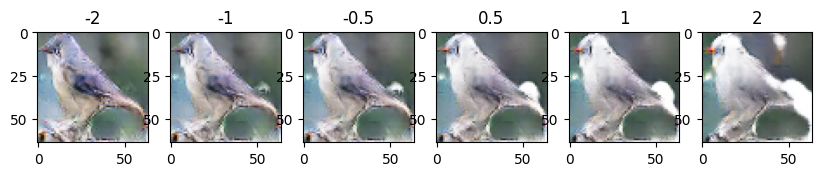

In [264]:
plot_feature_change(vals,11,noise)

Widać, że pojedyncze wartości wektorów szumu odpowiadają za cechy wyjściowe, takie jak kolor dzioba lub korpusu i rozmiar ogona.

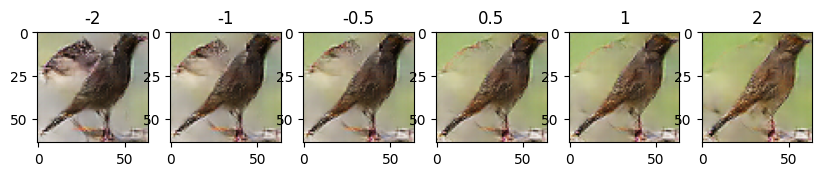

In [274]:
noise = np.random.normal(size=(1,LATENT_DIM)) #new noise
plot_feature_change(vals,11,noise)

Tutaj zmiana tej samej wartości na różnych wejściach prowadzi do podobnych rezultatów – stopniowej transformacji koloru. Jednocześnie wpływa to na inne części obrazu, przez co pojedyncze wartości z wektora szumu nie zawsze są dla nas łatwe do wyjaśnienia.

## <a id='toc1_2_'></a>[Zadania (4 punkty)](#toc0_)

* Eksperymentuj z niektórymi hiperparametrami GAN i obiema sieciami.
* Pokaż porównania wydajności modeli i opisz swoje wnioski.
* Spróbuj przeprowadzić takie eksperymenty na innym zbiorze danych treningowych pobranych z <a href="www.kaggle.com">Kaggle.com</a> i walcz z nadmiernym i niedostatecznym dopasowaniem.

Odeślij mi notatnik z rozwiązaniem, w którym zaprezentujesz eksperymenty i wyniki w osobnym notatniku.